In [2]:
import os

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "4"

import tensorflow as tf

import chiron


In [3]:
chiron.set_visible_gpus()


In [30]:
output_dir = "../results/fold-1-epochs-100-lr-1e-4-reduce-lr-patience-4-early-stopping-patience-16-per-image-standardization/"
epoch = 35

model = chiron.load_model(os.path.join(output_dir, "model.json"))
config = chiron.load_yaml(os.path.join(output_dir, "config.yaml"))
image_size = tf.TensorShape(config["image_size"])
model.build([None] + image_size + [3])
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              5919312   
_________________________________________________________________
dense (Dense)                (None, 3)                 3843      
Total params: 5,923,155
Trainable params: 5,862,547
Non-trainable params: 60,608
_________________________________________________________________


In [31]:
model.load_weights(
    os.path.join(
        output_dir, "weights", chiron.get_weights_path().format(epoch=epoch)
    )
)


In [44]:
data_file = "../data/brain-tumor-public-dataset/tfrecord/val/fold-1.tfrecord"
batch_size = 36
batch_index = 0

dataset = (
    chiron.load_tfrecord(data_file)
    .shuffle(batch_size * 10)
    .map(chiron.LabelMapper(config["label_map"]))
    .map(chiron.Resizer(image_size))
    .map(chiron.Repeater(3, axis=2))
    .map(chiron.ShapeSetter(image_size + [3]))
    .batch(batch_size)
    .map(chiron.PerImageStandardWhitener())
)

with tf.GradientTape() as tape:
    for images, labels in dataset.skip(batch_index).take(1):
        pass
    tape.watch(images)
    predictions = model(images, training=False)
    losses = tf.gather_nd(
        predictions, tf.stack([tf.range(batch_size), labels], axis=1)
    )
gradients = tape.gradient(losses, images)
saliency_maps = tf.reduce_max(gradients, axis=3)


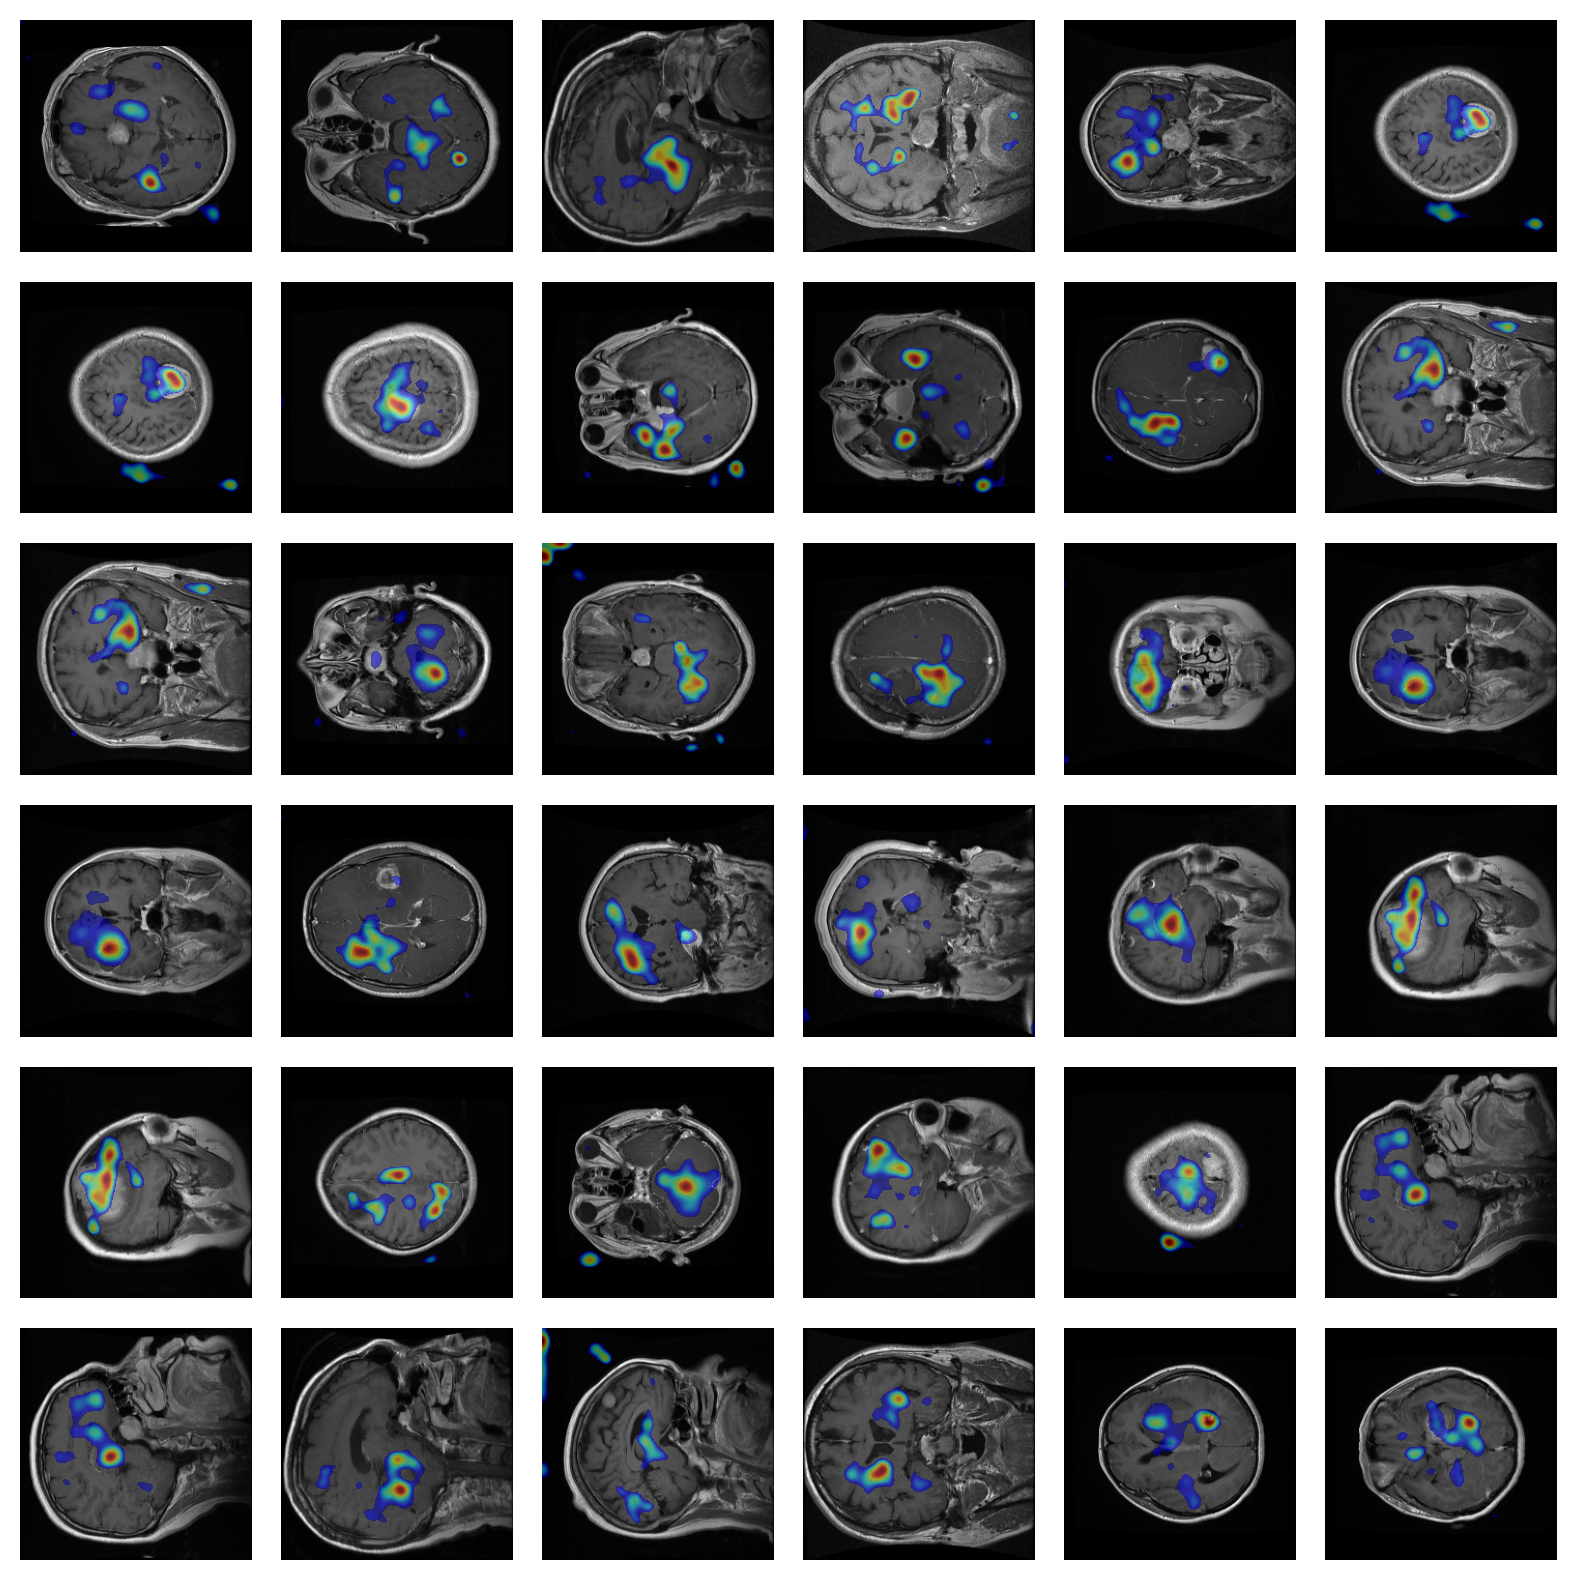

In [45]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import gaussian_filter

fig, axes = plt.subplots(6, 6, figsize=(8, 8), dpi=200)
for i in range(6):
    for j in range(6):
        k = i * 5 + j
        image = images[k]
        saliency_map = saliency_maps[k]
        ax = axes[i, j]
        ax.imshow(image[:, :, 0], cmap="gray")
        smoothed = gaussian_filter(saliency_map, 5)
        threshold = np.percentile(smoothed, 95)
        ax.imshow(
            np.where(smoothed > threshold, smoothed, np.nan),
            cmap="jet",
            alpha=0.5,
        )
        ax.set_axis_off()
        ax.set_aspect("equal")
fig.tight_layout()
